In [122]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectorMixin
from datetime import datetime as dt
from sklearn.model_selection import GridSearchCV

In [98]:
#permutation feature importance

#rozdzielić feature engineering
#dodać filtrowanie po korelacji dla numerycznych (min wywalić) (#demonstracje/a dla danych regresyjnych w pliku teoria)

In [99]:
#pobieranie CZĘŚCIOWO WYCZYSZCZONYCH danych

train_og = pd.read_csv("../data/processed/train_postprocessed.csv")
test_og =pd.read_csv("../data/processed/test_postprocessed.csv")

train = train_og.copy()
test = test_og.copy()

In [100]:
y = np.log1p(train["SalePrice"])
X = train.drop(columns=["SalePrice", "Id"])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_test = test.drop(columns=["Id"])

In [101]:
#przygotowujemy preprocessing 

num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
#tutaj tak naprawdę simpleimputer nie jest potrzebny, do wczytywane dane mają braki 'obrobione' (plik data.py)
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
]) 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
        ('cat', cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder='passthrough', #dodatkowo dodane, tak naprawdę nie mamy kolumn poza num i cat, więc ten krok można pominąć
    verbose_feature_names_out=False #skracanie nowych nazw kolumn
)

In [102]:
#Przygotowanie kroków Feature Engineering

In [103]:
#usuwanie pustych kolumn - doczyszczanie

class DropEmptyColumns(BaseEstimator, TransformerMixin):
    def __init__(self, drop_threshold = 0.9):
        self.drop_threshold = drop_threshold 
        self.cols_to_drop = []

    def fit(self, X, y=None):
        self.cols_to_drop = X.columns[(X.isna().mean() > self.drop_threshold) |
                                      ((X.select_dtypes(include=['int64', 'float64']) == 0).mean() > self.drop_threshold)]
        return self

    def transform(self, X):
        X = X.copy()

        X = X.drop(columns=self.cols_to_drop, errors='ignore')
        
        return X

In [104]:
#filtrowanie po korelacji DLA NUMERYCZNYCH

class CorrelationFiltering(BaseEstimator, SelectorMixin):
    def __init__(self, threshold=0.01):
        self.threshold = threshold
        self.correlations_ = []
    
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("y nie może być None dla CorrelationFiltering")
        
        self.is_dataframe_ = isinstance(X, pd.DataFrame)
        
        if self.is_dataframe_:
            self.numeric_cols_ = X.select_dtypes(include=[np.number]).columns.tolist()
            X_numeric = X[self.numeric_cols_]
            values = X_numeric.values
        else:
            values = X
            self.numeric_cols_ = None
        
        y_values = y.values if hasattr(y, 'values') else np.array(y)
        y_values = y_values.ravel()
        
        for i in range(values.shape[1]):
            col = values[:, i]
            if np.std(col) == 0:
                self.correlations_.append(0.0)
            else:
                corr = np.corrcoef(col, y_values)[0, 1]
                self.correlations_.append(0.0 if np.isnan(corr) else corr)
        
        self.correlations_ = np.array(self.correlations_)
        self.n_features_in_ = len(self.numeric_cols_) if self.is_dataframe_ else values.shape[1]
        
        if self.is_dataframe_:
            self.feature_names_in_ = np.array(self.numeric_cols_)
        
        return self
    
    def _get_support_mask(self):
        return np.abs(self.correlations_) > self.threshold
    
    def transform(self, X):
        if self.is_dataframe_:
            X = X[self.numeric_cols_]
        
        mask = self._get_support_mask()
        
        if self.is_dataframe_:
            selected_cols = np.array(self.numeric_cols_)[mask]
            return X[selected_cols]
        else:
            return X[:, mask]

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Log(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if 'LotArea' in X.columns:
            X['log_LotArea'] = np.log1p(X['LotArea'])
        if 'LotFrontage' in X.columns:
            X['log_LotFrontage'] = np.log1p(X['LotFrontage'])
        if 'MasVnrArea' in X.columns:
            X['log_MasVnrArea'] = np.log1p(X['MasVnrArea'])
        if 'WoodDeckSF' in X.columns:
            X['log_WoodDeckSF'] = np.log1p(X['WoodDeckSF'])
        
        return X 


In [106]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from datetime import datetime as dt

class AddNewColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):     
        X = X.copy()

        if 'MasVnrArea' in X.columns:
            X['HasMasVnrArea'] = (X['MasVnrArea'] > 0).astype('float64')

        if 'WoodDeckSF' in X.columns:
            X['HasWoodDeckSF'] = (X['WoodDeckSF'] > 0).astype('float64')

        if 'GarageYrBlt' in X.columns:
            X['GarageAge'] = dt.now().year - X['GarageYrBlt']
            X = X.drop(['GarageYrBlt'], axis=1)

        if all(col in X.columns for col in ['YrSold', 'YearRemodAdd', 'YearBuilt']):
            X['AgeAtSold'] = X['YrSold'] - X['YearBuilt']
            X['YearsSinceRemod'] = X['YrSold'] - X['YearRemodAdd'] 
            X['HouseAge'] = dt.now().year - X['YearBuilt']

        if 'MoSold' in X.columns:
            X['MoSold_sin'] = np.sin(2 * np.pi * X['MoSold'] / 12)
            X['MoSold_cos'] = np.cos(2 * np.pi * X['MoSold'] / 12)
            
            high_season_months = [4, 5, 6, 7, 8]  
            X['HighSeasonSell'] = X['MoSold'].isin(high_season_months).astype('int64')

        if 'GrLivArea' in X.columns and 'TotalBsmtSF' in X.columns:
            X['GrAndBsmtArea'] = X['GrLivArea'] + X['TotalBsmtSF']

        if all(col in X.columns for col in ['FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath']):
            X['Bathrooms'] = X['FullBath'] + X['BsmtFullBath'] + 0.5*(X['HalfBath'] + X['BsmtHalfBath'])

        if all(col in X.columns for col in ['OverallQual', 'OverallCond']):
            X['QualCondScore'] = X['OverallQual'] * X['OverallCond']

        return X


In [107]:
#usuwanie starych kolumn 

class DeleteUnnecessaryColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if all(col in X.columns for col in ['HasMasVnrArea', 'MasVnrArea']):
            X = X.drop(['MasVnrArea'], axis=1, errors='ignore')
        
        if all(col in X.columns for col in ['HasWoodDeckSF', 'WoodDeckSF']):
            X = X.drop(['WoodDeckSF'], axis=1, errors='ignore')
        
        if all(col in X.columns for col in ['GarageYrBlt', 'GarageAge']):
            X = X.drop(['GarageYrBlt'], axis=1, errors='ignore')
        
        # Wiek domu od sprzedaży 
        if all(col in X.columns for col in ['AgeAtSold', 'YearsSinceRemod', 'HouseAge', 'YrSold', 'YearRemodAdd', 'YearBuilt']):
            X = X.drop(['YearBuilt', 'YearRemodAdd', 'YrSold'], axis=1, errors='ignore')
        
        # Sezonowość
        if all(col in X.columns for col in ['MoSold', 'HighSeasonSell']):
            X = X.drop(['MoSold'], axis=1, errors='ignore')
        
        # Interakcja
        if all(col in X.columns for col in ['GrLivArea', 'TotalBsmtSF', 'GrAndBsmtArea']):
            X = X.drop(['TotalBsmtSF'], axis=1, errors='ignore')
        
        if all(col in X.columns for col in ['Bathrooms', 'FullBath', 'HalfBath', 'BsmtHalfBath', 'BsmtFullBath']):
            X = X.drop(['BsmtHalfBath', 'BsmtFullBath', 'FullBath', 'HalfBath'], axis=1, errors='ignore')
       
        return X

In [108]:
from sklearn.ensemble import GradientBoostingRegressor

#custom transformer do selekcji cech opartej na feature importance

class FeatureImportanceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.001, n_estimators=100, random_state=42):
        self.threshold = threshold
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.feature_mask_ = None
        self.feature_importances_ = None
        self.n_features_in_ = None
        self.n_features_out_ = None
    
    def fit(self, X, y):
        if hasattr(X, 'toarray'): 
            X = X.toarray()
        
        self.n_features_in_ = X.shape[1]
        
        #pomocniczy GB model
        temp_model = GradientBoostingRegressor(
            n_estimators=self.n_estimators,
            learning_rate=0.05,
            max_depth=4,
            random_state=self.random_state
        )
        temp_model.fit(X, y)
        
        self.feature_importances_ = temp_model.feature_importances_

        self.feature_mask_ = self.feature_importances_ >= self.threshold
        self.n_features_out_ = self.feature_mask_.sum()
        
        return self
    
    def transform(self, X):
        if self.feature_mask_ is None:
            raise ValueError("FeatureImportanceSelector must be fitted before transform!")
        
        if hasattr(X, 'toarray'):  # sparse matrix
            X = X.toarray()
        
        return X[:, self.feature_mask_]
    
    def get_selected_features(self, feature_names):
        if self.feature_mask_ is None:
            raise ValueError("FeatureImportanceSelector must be fitted first!")
        
        return [name for name, selected in zip(feature_names, self.feature_mask_) if selected]

In [109]:
#Gradient Boosting

#bez optymalizacji
gb_model = Pipeline([
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#z usuwaniem pustych kolumn
gb_model_del_empty = Pipeline([
    ("del_empty", DropEmptyColumns()),
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#z filtrowaniem po korelacji
gb_model_corr = Pipeline([
    ("corr", CorrelationFiltering()),
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#z dodawaniem nowych kolumn
gb_model_add = Pipeline([
    ("add", AddNewColumns()),
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#z dodawaniem nowych i dropnięciem starych
gb_model_add_del = Pipeline([
    ("add", AddNewColumns()),
    ("del", DeleteUnnecessaryColumns()),
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#logarytmizowanie
gb_model_log = Pipeline([
    ("log", Log()),
    ("prep", preprocessor),
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#połączenie wszystkich optymalizacji (poza filtrowaniem po korelacji)
gb_model_all = Pipeline([
    ("log", Log()),
    ("add", AddNewColumns()),
    ("del", DeleteUnnecessaryColumns()),
    ("del_empty", DropEmptyColumns()),
    ("prep", preprocessor),
    ("feature_selection", FeatureImportanceSelector(threshold=0.00001)), #zamiana kolejności z preprocessorem
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

#feature selection
gb_model_fis = Pipeline([
    ("prep", preprocessor),
    ("feature_selection", FeatureImportanceSelector(threshold=0.00001)), #zamiana kolejności z preprocessorem
    ("model", GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

In [110]:
#Elastic Net

#bez optymalizacji
enet_model = Pipeline([
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#z usuwaniem pustych kolumn
enet_model_del_empty = Pipeline([
    ("del_empty", DropEmptyColumns()),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#z filtrowaniem po korelacji
enet_model_corr = Pipeline([
    ("corr", CorrelationFiltering(threshold=0.001)),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#z dodawaniem nowych kolumn
enet_model_add = Pipeline([
    ("add", AddNewColumns()),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#z dodawaniem nowych i dropnięciem starych
enet_model_add_del = Pipeline([
    ("add", AddNewColumns()),
    ("del", DeleteUnnecessaryColumns()),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#logarytmizowanie
enet_model_log = Pipeline([
    ("log", Log()),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#połączenie wszystkich optymalizacji
enet_model_all = Pipeline([
    ("log", Log()),
    ("add", AddNewColumns()),
    ("del", DeleteUnnecessaryColumns()),
    ("corr", CorrelationFiltering()),
    ("del_empty", DropEmptyColumns()),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

#połączenie tylko log, add
enet_model_la = Pipeline([
    ("log", Log()),
    ("add", AddNewColumns()),
    ("prep", preprocessor),
    ("model", ElasticNet(alpha=0.001, l1_ratio=0.5))
])

In [111]:
#Elastic Net (liniowy)

#bez optymalizacji
enet_model.fit(X_train, y_train)
pred_enet = enet_model.predict(X_val)

#z usuwaniem pustych kolumn
enet_model_del_empty.fit(X_train, y_train)
pred_enet_del_empty = enet_model_del_empty.predict(X_val)

#z filtrowaniem po korelacji
enet_model_corr.fit(X_train, y_train)
pred_enet_corr = enet_model_corr.predict(X_val)

#z dodawaniem nowych kolumn
enet_model_add.fit(X_train, y_train)
pred_enet_add = enet_model_add.predict(X_val)

#z dodawaniem nowych i dropnięciem starych
enet_model_add_del.fit(X_train, y_train)
pred_enet_add_del = enet_model_add_del.predict(X_val)

#logarytmizowanie
enet_model_log.fit(X_train, y_train)
pred_enet_log = enet_model_log.predict(X_val)

#połączenie wszystkich optymalizacji
enet_model_all.fit(X_train, y_train)
pred_enet_all = enet_model_all.predict(X_val)

#połączenie tylko log, add, drop_empty
enet_model_la.fit(X_train, y_train)
pred_enet_la = enet_model_la.predict(X_val)

In [112]:
#Gradient Boosting (drzewiasty)

#bez optymalizacji 
gb_model.fit(X_train, y_train)
pred_gb = gb_model.predict(X_val)

#z usuwaniem pustych kolumn
gb_model_del_empty.fit(X_train, y_train)
pred_gb_del_empty = gb_model_del_empty.predict(X_val)

"""#z filtrowaniem po korelacji - NIE DLA DRZEWIASTEGO
gb_model_corr.fit(X_train, y_train)
pred_gb_corr = gb_model_corr.predict(X_val)"""

#z dodawaniem nowych kolumn
gb_model_add.fit(X_train, y_train)
pred_gb_add = gb_model_add.predict(X_val)

#z dodawaniem nowych i dropnięciem starych
gb_model_add_del.fit(X_train, y_train)
pred_gb_add_del = gb_model_add_del.predict(X_val)

#logarytmizowanie
gb_model_log.fit(X_train, y_train)
pred_gb_log = gb_model_log.predict(X_val)

#połączenie wszystkich optymalizacji
gb_model_all.fit(X_train, y_train)
pred_gb_all = gb_model_all.predict(X_val)

#fis
gb_model_fis.fit(X_train, y_train)
pred_gb_fis = gb_model_fis.predict(X_val)

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Lista modeli i ich predykcji
models = ['ElasticNet', 'Gradient Boosting', 'ENET_drop_empty', 'GB_drop_empty', 'ENET_corr',  
         'ENET_add', 'GB_add', 'ENET_add_del', 'GB_add_del', 'ENET_log', 'GB_log',
         'ENET_all', 'GB_all', 'ENET_log_add', 'GB_feature_selection']
predictions = [pred_enet, pred_gb, pred_enet_del_empty, pred_gb_del_empty, pred_enet_corr, 
              pred_enet_add, pred_enet_add_del, pred_gb_add, pred_gb_add_del, pred_enet_log, pred_gb_log,
              pred_enet_all, pred_gb_all, pred_enet_la, pred_gb_fis]

# obliczanie metryk
results = []
for name, pred in zip(models, predictions):
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    mae = mean_absolute_error(y_val, pred)
    r2 = r2_score(y_val, pred)
    results.append([name, rmse, mae, r2])

# tworzenie DataFrame i sortowanie po R2
df_results = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])
df_results = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
df_results

,Model,RMSE,MAE,R2
0,GB_add,0.098015,0.071593,0.890215
1,ENET_log_add,0.098065,0.070804,0.890103
2,ENET_log,0.098198,0.070974,0.889804
3,ENET_add,0.098881,0.071761,0.888265
4,ElasticNet,0.098935,0.071821,0.888144
5,ENET_drop_empty,0.100740,0.073582,0.884024
6,ENET_all,0.108731,0.080794,0.864896
7,GB_add_del,0.110521,0.077066,0.860411
8,ENET_add_del,0.111173,0.076070,0.858759
9,GB_feature_selection,0.111816,0.077803,0.857120


In [114]:
#wybór najlepszych pipeline'ów na podstawie metryk

#normalizowanie metryk i obliczanie średniej
df_results['RMSE_norm'] = (df_results['RMSE'].max() - df_results['RMSE']) / (df_results['RMSE'].max() - df_results['RMSE'].min())
df_results['MAE_norm'] = (df_results['MAE'].max() - df_results['MAE']) /  (df_results['MAE'].max() - df_results['MAE'].min())
df_results['R2_norm'] = (df_results['R2'] - df_results['R2'].min()) / (df_results['R2'].max() - df_results['R2'].min())

#średnia ważona
df_results['Combined_Score'] = (
    0.5 * df_results['RMSE_norm'] +  
    0.3 * df_results['MAE_norm'] +   
    0.2 * df_results['R2_norm']  
)

df_results.sort_values('Combined_Score', ascending=False)

,Model,RMSE,MAE,R2,RMSE_norm,MAE_norm,R2_norm,Combined_Score
1,ENET_log_add,0.098065,0.070804,0.890103,0.997140,1.000000,0.997374,0.998045
2,ENET_log,0.098198,0.070974,0.889804,0.989522,0.986585,0.990371,0.988811
0,GB_add,0.098015,0.071593,0.890215,1.000000,0.937608,1.000000,0.981282
3,ENET_add,0.098881,0.071761,0.888265,0.950417,0.924340,0.954275,0.943366
4,ElasticNet,0.098935,0.071821,0.888144,0.947374,0.919619,0.951455,0.939864
5,ENET_drop_empty,0.100740,0.073582,0.884024,0.844074,0.780401,0.854849,0.827127
7,GB_add_del,0.110521,0.077066,0.860411,0.284479,0.504942,0.301142,0.353951
8,ENET_add_del,0.111173,0.076070,0.858759,0.247184,0.583656,0.262417,0.351172
6,ENET_all,0.108731,0.080794,0.864896,0.386902,0.210209,0.406321,0.337778
9,GB_feature_selection,0.111816,0.077803,0.857120,0.210382,0.446718,0.223982,0.284003


In [131]:
#zapis najlepszych piplienów

import joblib

joblib.dump(enet_model_la, "best_enet_pipeline.pkl")
joblib.dump(gb_model_add, "best_gb_pipeline.pkl")

['best_gb_pipeline.pkl']

# Optymalizacja modeli

In [123]:
# ElasticNet - regularyzacja i GridSearchCV

enet_param_grid = {
    "model__alpha": [0.0001, 0.001, 0.01, 0.1],
    "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

enet_grid = GridSearchCV(
    estimator=enet_model_la,
    param_grid=enet_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

enet_grid.fit(X_train, y_train)

best_enet_pipeline = enet_grid.best_estimator_

print("ElasticNet BEST params:", enet_grid.best_params_)
print("ElasticNet BEST CV RMSE:", -enet_grid.best_score_)


ElasticNet BEST params: {'model__alpha': 0.001, 'model__l1_ratio': 0.9}
ElasticNet BEST CV RMSE: 0.11038763345351361


In [183]:
# Gradient Boosting - optymailziacja hyperparametrów Grid

gb_param_grid = {
    "model__n_estimators": [200, 300, 500],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.8, 1.0]
}

gb_grid = GridSearchCV(
    estimator=gb_model_add,
    param_grid=gb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

best_gb_pipeline = gb_grid.best_estimator_

print("GB BEST params:", gb_grid.best_params_)
print("GB BEST CV RMSE:", -gb_grid.best_score_)


GB BEST params: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 500, 'model__subsample': 0.8}
GB BEST CV RMSE: 0.11402089405126632


In [184]:
# tworzenie tabeli porównawczej

preds_path = "../data/predictions/model_predictions.csv"
df_preds_base = pd.read_csv(preds_path)
y_val_array = df_preds_base['y_true'].values

def eval_preds(y_true, y_pred, model_name, stage):
    return {
        "Model": model_name,
        "Etap": stage,
        "RMSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

def eval_model(model, X_train, y_train, X_val, y_val, stage, model_name):
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    return {
        "Model": model_name,
        "Etap": stage,
        "RMSE": mean_squared_error(y_val, y_pred_val),
        "R2": r2_score(y_val, y_pred_val)
    }

results = []

# ElasticNet
results.append(eval_preds(y_val_array, df_preds_base['ElasticNet'].values, "ElasticNet", "Bazowy"))
results.append(eval_model(enet_model_la, X_train, y_train, X_val, y_val, "Pipeline", "ElasticNet"))
results.append(eval_model(best_enet_pipeline, X_train, y_train, X_val, y_val, "Pipeline + Tuning", "ElasticNet"))

# GradientBoosting
results.append(eval_preds(y_val_array, df_preds_base['GradientBoosting'].values, "GradientBoosting", "Bazowy"))
results.append(eval_model(gb_model_add, X_train, y_train, X_val, y_val, "Pipeline", "GradientBoosting"))
results.append(eval_model(best_gb_pipeline, X_train, y_train, X_val, y_val, "Pipeline + Tuning", "GradientBoosting"))

df_results = pd.DataFrame(results)

df_rmse = df_results.pivot(index='Model', columns='Etap', values='RMSE')
df_r2 = df_results.pivot(index='Model', columns='Etap', values='R2')

df = pd.concat([df_rmse.add_suffix(" (RMSE)"), df_r2.add_suffix(" (R2)")], axis=1)


df

Etap,Bazowy (RMSE),Pipeline (RMSE),Pipeline + Tuning (RMSE),Bazowy (R2),Pipeline (R2),Pipeline + Tuning (R2)
Model,,,,,,
ElasticNet,0.009417,0.009617,0.009951,0.892381,0.890103,0.886285
GradientBoosting,0.012406,0.012359,0.012131,0.858222,0.858759,0.861369


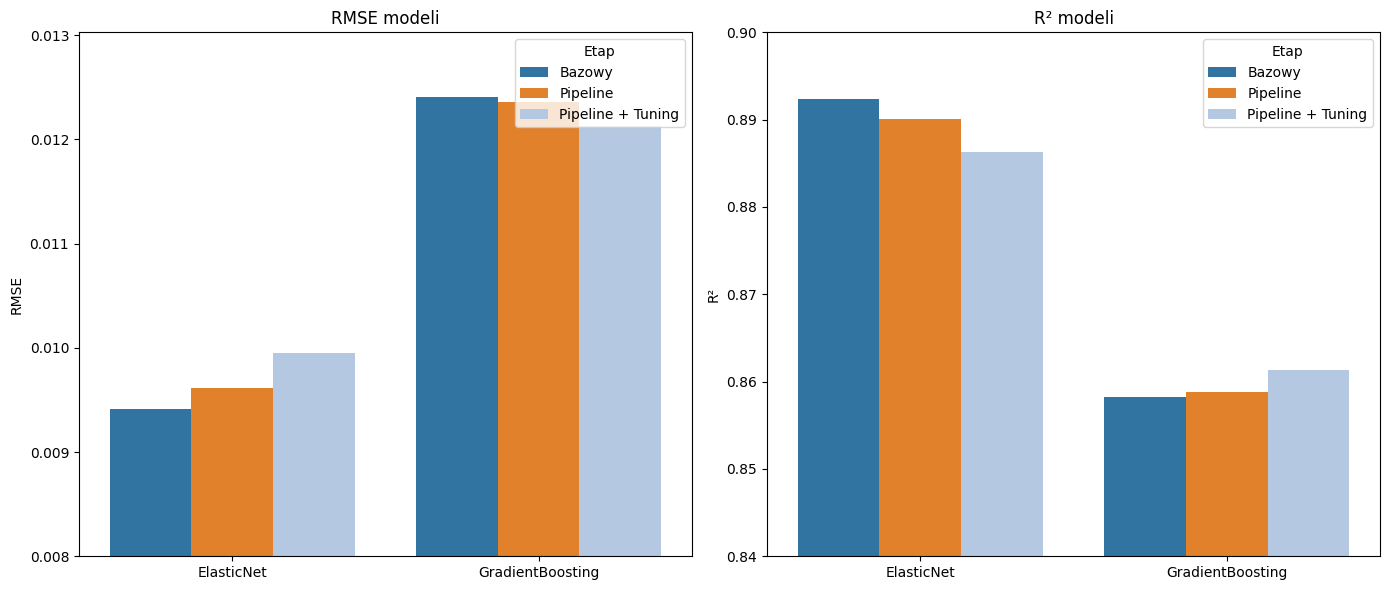

In [185]:
# wykres porównawczy

import matplotlib.pyplot as plt
import seaborn as sns

# Kolory: niebieski i pomarańczowy dla etapów
palette = ["#1f77b4", "#ff7f0e", "#aec7e8"]  # Bazowy, Pipeline, Pipeline + Tuning

# Przygotowanie danych
df_plot = df_results.melt(id_vars=['Model', 'Etap'], value_vars=['RMSE', 'R2'], 
                          var_name='Metric', value_name='Score')

# Oddzielne wykresy dla RMSE i R2
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# RMSE
sns.barplot(data=df_plot[df_plot['Metric']=='RMSE'], x='Model', y='Score', hue='Etap', palette=palette, ax=axes[0])
axes[0].set_title('RMSE modeli')
axes[0].set_ylabel('RMSE')
axes[0].set_xlabel('')
axes[0].set_ylim(0.008, None) 
axes[0].legend(title='Etap', loc='upper right')

# R2
sns.barplot(data=df_plot[df_plot['Metric']=='R2'], x='Model', y='Score', hue='Etap', palette=palette, ax=axes[1])
axes[1].set_title('R² modeli')
axes[1].set_ylabel('R²')
axes[1].set_xlabel('')
axes[1].set_ylim(0.84, 0.9) 
axes[1].legend(title='Etap', loc='upper right')

plt.tight_layout()
plt.show()
